In [9]:
# CELL 1: Imports & Setup (FIXED - Creates directories automatically)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from scipy.stats import ttest_ind, chi2_contingency
import joblib
import warnings
warnings.filterwarnings('ignore')

# ✅ CREATE ALL DIRECTORIES AUTOMATICALLY
os.makedirs('data', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('notebooks', exist_ok=True)

# Load data (move OCD-data.csv to data/ folder first)
df = pd.read_csv('../data/OCD-data.csv')
print("✅ Dataset loaded:", df.shape)
print("✅ Directories created: data/, models/")
df.head()


✅ Dataset loaded: (1500, 17)
✅ Directories created: data/, models/


,Patient ID,Age,Gender,Ethnicity,Marital Status,Education Level,OCD Diagnosis Date,Duration of Symptoms (months),Previous Diagnoses,Family History of OCD,Obsession Type,Compulsion Type,Y-BOCS Score (Obsessions),Y-BOCS Score (Compulsions),Depression Diagnosis,Anxiety Diagnosis,Medications
0,1018,32,Female,African,Single,Some College,2016-07-15,203,MDD,No,Harm-related,Checking,17,10,Yes,Yes,SNRI
1,2406,69,Male,African,Divorced,Some College,2017-04-28,180,NaN,Yes,Harm-related,Washing,21,25,Yes,Yes,SSRI
2,1188,57,Male,Hispanic,Divorced,College Degree,2018-02-02,173,MDD,No,Contamination,Checking,3,4,No,No,Benzodiazepine
3,6200,27,Female,Hispanic,Married,College Degree,2014-08-25,126,PTSD,Yes,Symmetry,Washing,14,28,Yes,Yes,SSRI
4,5824,56,Female,Hispanic,Married,High School,2022-02-20,168,PTSD,Yes,Hoarding,Ordering,39,18,No,No,NaN


In [10]:
# Date conversion and feature engineering
df['OCD Diagnosis Date'] = pd.to_datetime(df['OCD Diagnosis Date'])
df['Previous Diagnoses'].fillna('None', inplace=True)
df['Total Y-BOCS Score'] = df['Y-BOCS Score (Obsessions)'] + df['Y-BOCS Score (Compulsions)']

def severity_category(score):
    if score <= 15: return 'Mild'
    elif score <= 30: return 'Moderate'
    else: return 'Severe'
df['Severity Category'] = df['Total Y-BOCS Score'].apply(severity_category)
df['Diagnosis Year'] = df['OCD Diagnosis Date'].dt.year

print("Missing values:\n", df.isnull().sum())
print("\nSeverity distribution:\n", df['Severity Category'].value_counts())


Missing values:
 Patient ID                         0
Age                                0
Gender                             0
Ethnicity                          0
Marital Status                     0
Education Level                    0
OCD Diagnosis Date                 0
Duration of Symptoms (months)      0
Previous Diagnoses                 0
Family History of OCD              0
Obsession Type                     0
Compulsion Type                    0
Y-BOCS Score (Obsessions)          0
Y-BOCS Score (Compulsions)         0
Depression Diagnosis               0
Anxiety Diagnosis                  0
Medications                      386
Total Y-BOCS Score                 0
Severity Category                  0
Diagnosis Year                     0
dtype: int64

Severity distribution:
 Severity Category
Severe      1044
Moderate     325
Mild         131
Name: count, dtype: int64


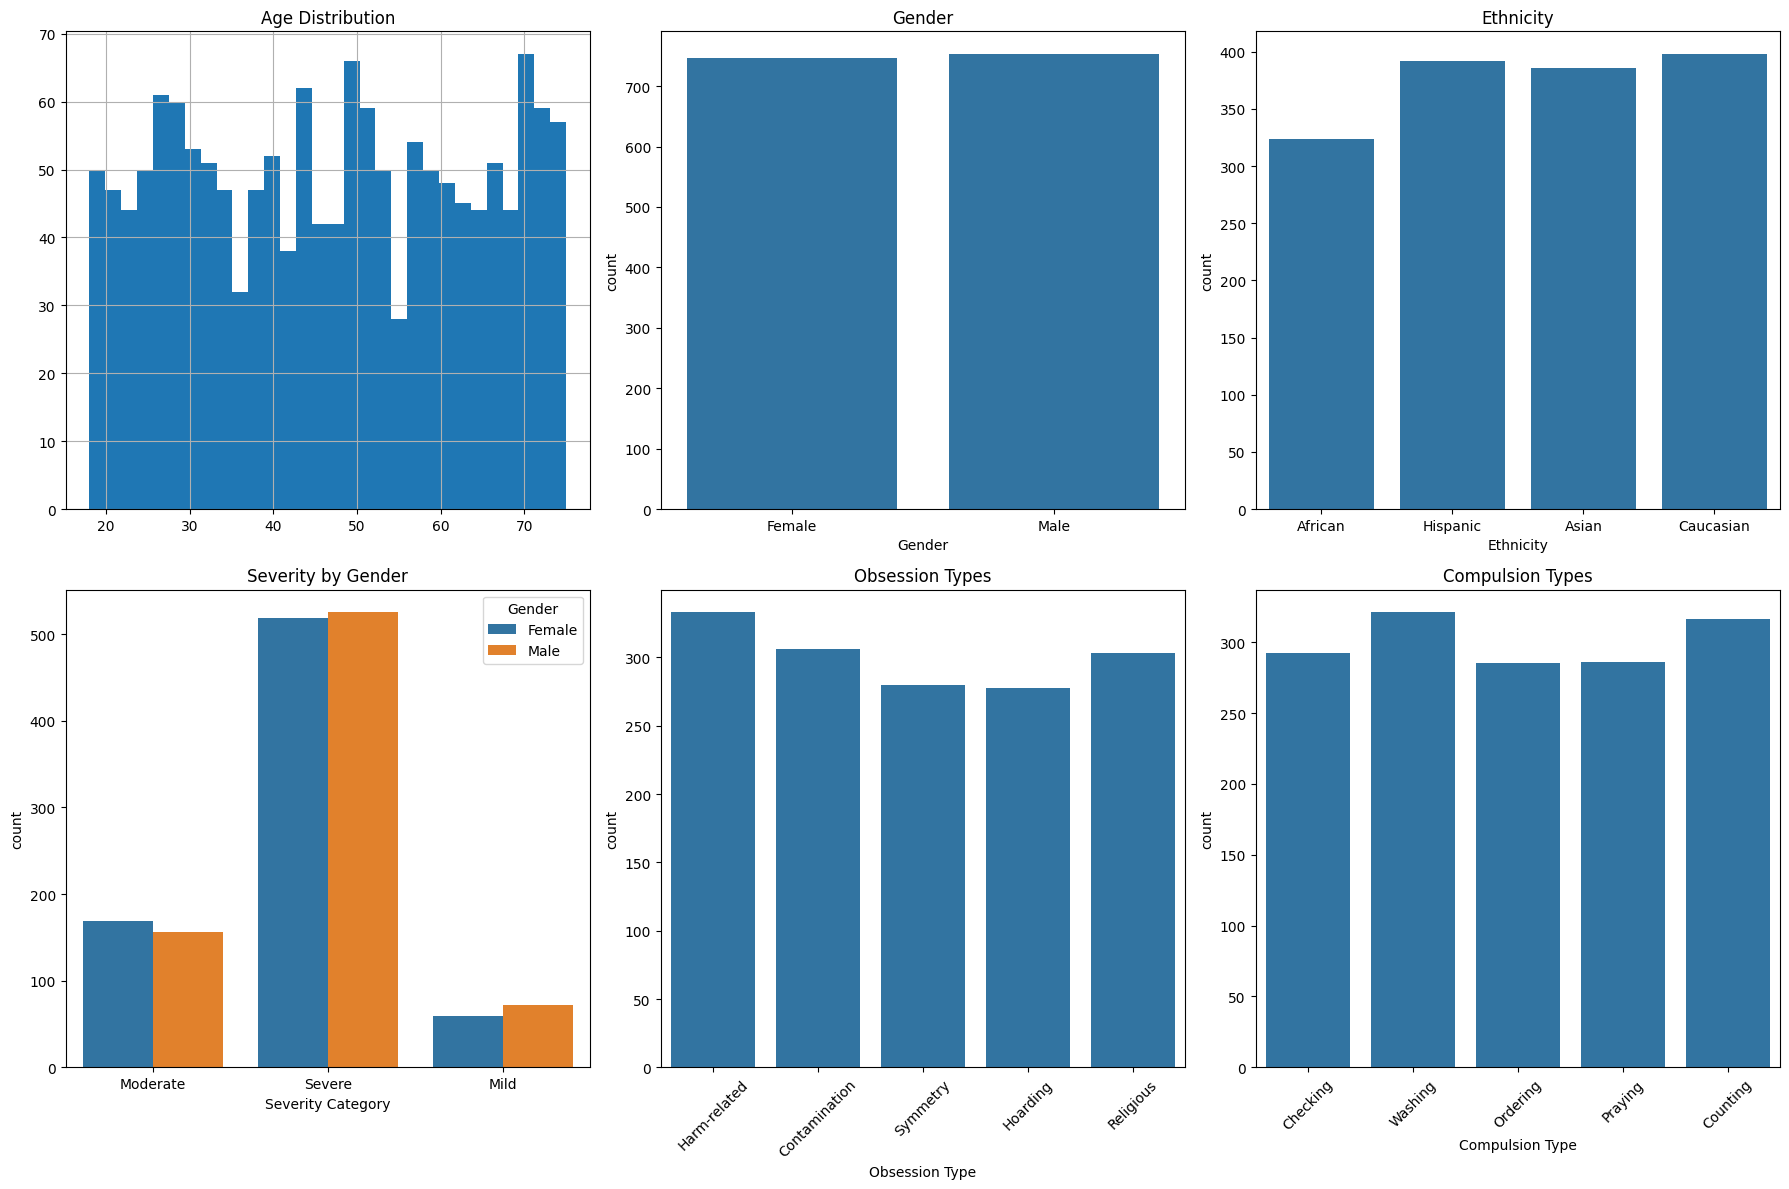

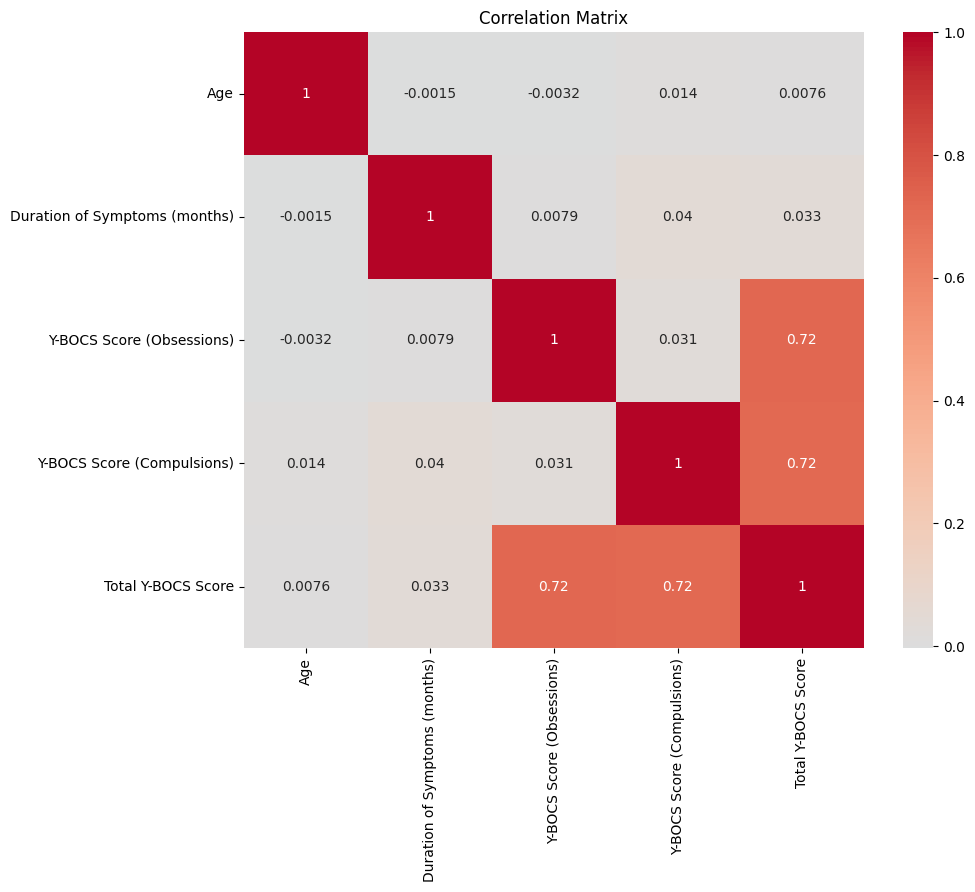

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
df['Age'].hist(bins=30, ax=axes[0,0]); axes[0,0].set_title('Age Distribution')
sns.countplot(data=df, x='Gender', ax=axes[0,1]); axes[0,1].set_title('Gender')
sns.countplot(data=df, x='Ethnicity', ax=axes[0,2]); axes[0,2].set_title('Ethnicity')
sns.countplot(data=df, x='Severity Category', hue='Gender', ax=axes[1,0]); axes[1,0].set_title('Severity by Gender')
sns.countplot(data=df, x='Obsession Type', ax=axes[1,1]); axes[1,1].tick_params(axis='x', rotation=45); axes[1,1].set_title('Obsession Types')
sns.countplot(data=df, x='Compulsion Type', ax=axes[1,2]); axes[1,2].tick_params(axis='x', rotation=45); axes[1,2].set_title('Compulsion Types')
plt.tight_layout()
plt.show()

# Correlation heatmap
numeric_cols = ['Age', 'Duration of Symptoms (months)', 'Y-BOCS Score (Obsessions)', 
                'Y-BOCS Score (Compulsions)', 'Total Y-BOCS Score']
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()


In [12]:
# T-test: Gender vs Y-BOCS scores
male_scores = df[df['Gender'] == 'Male']['Total Y-BOCS Score']
female_scores = df[df['Gender'] == 'Female']['Total Y-BOCS Score']
t_stat, p_val = ttest_ind(male_scores, female_scores)
print(f"T-test Gender vs Y-BOCS: t={t_stat:.2f}, p={p_val:.4f}")

# Chi-square: Family history vs severity
contingency = pd.crosstab(df['Family History of OCD'], df['Severity Category'])
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi-square Family History vs Severity: chi2={chi2:.2f}, p={p:.4f}")

# Group stats
print("\nMean Y-BOCS by Obsession Type:")
print(df.groupby('Obsession Type')['Total Y-BOCS Score'].mean().round(2))


T-test Gender vs Y-BOCS: t=-0.27, p=0.7875
Chi-square Family History vs Severity: chi2=1.09, p=0.5786

Mean Y-BOCS by Obsession Type:
Obsession Type
Contamination    39.89
Harm-related     40.41
Hoarding         39.76
Religious        39.71
Symmetry         38.43
Name: Total Y-BOCS Score, dtype: float64


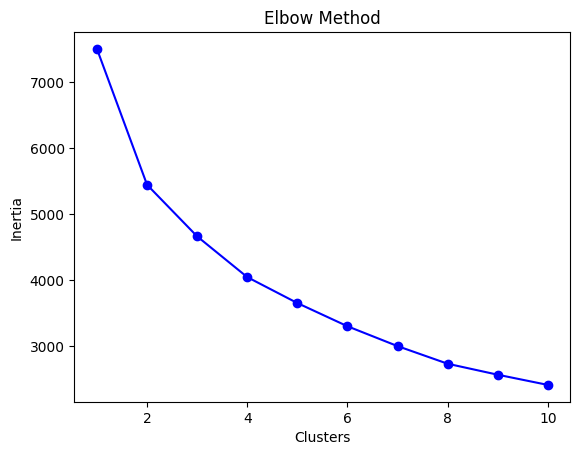

Cluster means:
            Age  Duration of Symptoms (months)  Y-BOCS Score (Obsessions)  \
Cluster                                                                    
0        47.12                         121.60                       8.88   
1        46.16                         123.70                      30.45   
2        46.87                         120.52                      24.19   

         Y-BOCS Score (Compulsions)  Total Y-BOCS Score  
Cluster                                                  
0                             14.20               23.07  
1                             10.50               40.95  
2                             31.64               55.83  


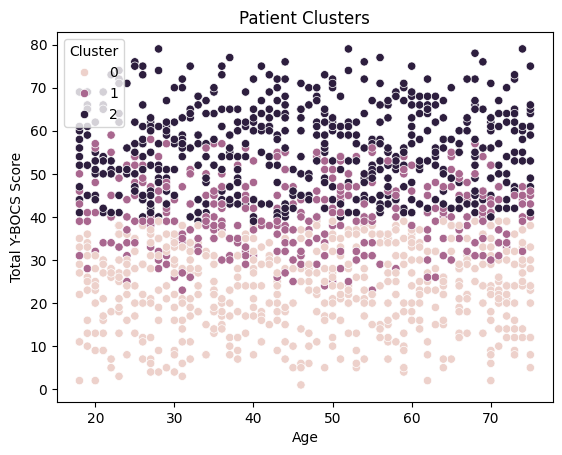

In [13]:
# K-means clustering
cluster_features = ['Age', 'Duration of Symptoms (months)', 'Y-BOCS Score (Obsessions)', 
                   'Y-BOCS Score (Compulsions)', 'Total Y-BOCS Score']
X_cluster = df[cluster_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Elbow method
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 11), inertias, 'bo-')
plt.title('Elbow Method'); plt.xlabel('Clusters'); plt.ylabel('Inertia')
plt.show()

# 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

print("Cluster means:\n", df.groupby('Cluster')[cluster_features].mean().round(2))
sns.scatterplot(data=df, x='Age', y='Total Y-BOCS Score', hue='Cluster')
plt.title('Patient Clusters')
plt.show()


In [14]:
# ML Model

# Define categorical columns
categorical_cols = ['Gender', 'Ethnicity', 'Marital Status', 'Education Level', 
                   'Previous Diagnoses', 'Family History of OCD', 'Obsession Type', 
                   'Compulsion Type', 'Depression Diagnosis', 'Anxiety Diagnosis']

# ✅ SAFE ENCODING - Only encode columns that exist and handle NaN
le_dict = {}
encoded_cols = []

print("📊 Available columns:", df.columns.tolist())
print("\n🔍 Encoding categorical columns...")

for col in categorical_cols:
    if col in df.columns:
        print(f"✅ Encoding: {col}")
        le = LabelEncoder()
        # Fill NaN with 'Missing' and encode
        df[col] = df[col].fillna('Missing')
        df[col + '_encoded'] = le.fit_transform(df[col])
        le_dict[col] = le
        encoded_cols.append(col + '_encoded')
    else:
        print(f"❌ Missing column: {col}")

#  DYNAMIC FEATURE LIST - Only existing columns
numeric_features = ['Age', 'Duration of Symptoms (months)']
feature_cols = [col for col in numeric_features + encoded_cols if col in df.columns]
print(f"\n Using {len(feature_cols)} features: {feature_cols[:5]}...")

X = df[feature_cols].copy()
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(df['Severity Category'])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, 
                                                    random_state=42, stratify=y_encoded)

print(f"\n Dataset split: Train={X_train.shape}, Test={X_test.shape}")

# Cross-validation baseline
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_base = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores = cross_val_score(rf_base, X_train, y_train, cv=cv, scoring='accuracy')
print(f"Baseline CV: {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")

# GridSearchCV (smaller grid for speed)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42), 
    param_grid, 
    cv=cv, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1
)
rf_grid.fit(X_train, y_train)

print(f"\n🎯 Best params: {rf_grid.best_params_}")
print(f"Best CV Accuracy: {rf_grid.best_score_:.3f}")

# Final evaluation
best_rf = rf_grid.best_estimator_
y_pred = best_rf.predict(X_test)
print("\n📊 Test Results:")
print(classification_report(y_test, y_pred, target_names=le_target.classes_))

# Feature importance (only for available features)
importances = pd.DataFrame({
    'feature': feature_cols, 
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🏆 Top 10 Features:")
print(importances.head(10))

# ✅ SAFE SAVE
joblib.dump(best_rf, 'models/ocd_model.pkl')
joblib.dump(le_dict, 'models/label_encoders.pkl')
joblib.dump(le_target, 'models/target_encoder.pkl')
joblib.dump(feature_cols, 'models/feature_cols.pkl')
print("\n✅ ALL MODELS SAVED SUCCESSFULLY!")



📊 Available columns: ['Patient ID', 'Age', 'Gender', 'Ethnicity', 'Marital Status', 'Education Level', 'OCD Diagnosis Date', 'Duration of Symptoms (months)', 'Previous Diagnoses', 'Family History of OCD', 'Obsession Type', 'Compulsion Type', 'Y-BOCS Score (Obsessions)', 'Y-BOCS Score (Compulsions)', 'Depression Diagnosis', 'Anxiety Diagnosis', 'Medications', 'Total Y-BOCS Score', 'Severity Category', 'Diagnosis Year', 'Cluster']

🔍 Encoding categorical columns...
✅ Encoding: Gender
✅ Encoding: Ethnicity
✅ Encoding: Marital Status
✅ Encoding: Education Level
✅ Encoding: Previous Diagnoses
✅ Encoding: Family History of OCD
✅ Encoding: Obsession Type
✅ Encoding: Compulsion Type
✅ Encoding: Depression Diagnosis
✅ Encoding: Anxiety Diagnosis

 Using 12 features: ['Age', 'Duration of Symptoms (months)', 'Gender_encoded', 'Ethnicity_encoded', 'Marital Status_encoded']...

 Dataset split: Train=(1200, 12), Test=(300, 12)
Baseline CV: 0.683 (+/- 0.012)
Fitting 5 folds for each of 24 candidates,